In [86]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [56]:
orbitals = {
    (1, 0, 0): lambda r, theta, phi: np.exp(-r),
    (2, 0, 0): lambda r, theta, phi: (2 - r) * np.exp(-r/2),
    (2, 1, 0): lambda r, theta, phi: r * np.exp(-r/2) * np.cos(theta),
    (2, 1, -1): lambda r, theta, phi: r * np.exp(-r/2) * np.sin(theta) * np.exp(-1j*phi),
    (2, 1, 1): lambda r, theta, phi: r * np.exp(-r/2) * np.sin(theta) * np.exp(1j*phi),
    (3, 0, 0): lambda r, theta, phi: (27 - 18*r + 2*r**2) * np.exp(-r/3),
    (3, 1, 0): lambda r, theta, phi: r * (6 - r) * np.exp(-r/3) * np.cos(theta),
    (3, 1, -1): lambda r, theta, phi: r * (6 - r) * np.exp(-r/3) * np.sin(theta) * np.exp(-1j*phi),
    (3, 1, 1): lambda r, theta, phi: r * (6 - r) * np.exp(-r/3) * np.sin(theta) * np.exp(1j*phi),
    (3, 2, 0): lambda r, theta, phi: r**2 * np.exp(-r/3) * (3 * np.cos(theta)**2 - 1),
    (3, 2, -1): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta) * np.cos(theta) * np.exp(-1j*phi),
    (3, 2, 1): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta) * np.cos(theta) * np.exp(1j*phi),
    (3, 2, -2): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta)**2 * np.exp(-2j*phi),
    (3, 2, 2): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta)**2 * np.exp(2j*phi),
}

orbital_names = {
    (1, 0, 0): "1s",
    (2, 0, 0): "2s",
    (2, 1, 0): "2p_z",
    (2, 1, -1): "2p_y",
    (2, 1, 1): "2p_x",
    (3, 0, 0): "3s",
    (3, 1, 0): "3p_z",
    (3, 1, -1): "3p_y",
    (3, 1, 1): "3p_x",
    (3, 2, 0): "3d_z2",
    (3, 2, -1): "3d_yz",
    (3, 2, 1): "3d_xz",
    (3, 2, -2): "3d_xy",
    (3, 2, 2): "3d_x2-y2",
}

In [79]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def plane_cartesian_to_spherical(x, y, plane=0):
    match plane:
        case 0: point = (x, y, 0)  # XY plane
        case 1: point = (0, x, y)  # YZ plane
        case 2: point = (y, 0, x)  # ZX plane
    return cartesian_to_spherical(*point)

In [91]:
def sample_distribution(orbital_func, n_samples=10000, plane=0):

    # Find the max
    max = 0
    for i in range(100000):
        x, y = np.random.uniform(-30, 30, size=2)
        r, theta, phi = plane_cartesian_to_spherical(x, y, plane)
        value = abs(orbital_func(r, theta, phi))**2
        if value > max:
            max = value

    # Find the bounds
    bound = 30
    while True:
        r, theta, phi = plane_cartesian_to_spherical(bound, bound, plane)
        value = abs(orbital_func(r, theta, phi))**2
        if value >= max * 0.001:
            bound += 1
            break
        else:
            bound -= 1

    print(max, bound)

    # Make the samples
    pool = ThreadPoolExecutor(max_workers=8)
    futures = [pool.submit(generate_samples, n_samples // 8, bound, max, orbital_func, plane) for _ in range(8)]
    samples = np.vstack([future.result() for future in futures])
    return samples


def generate_samples(n_samples, bound, max, orbital_func, plane):
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.uniform(-bound, bound, size=2)
        r, theta, phi = plane_cartesian_to_spherical(x, y, plane)
        value = abs(orbital_func(r, theta, phi))**2
        threshold = np.random.uniform(0, max)
        if threshold < value:
            samples.append((x, y))
    return np.array(samples)


0.9070495715446034 3
0.9258940697646899 3
0.9317233494206925 3


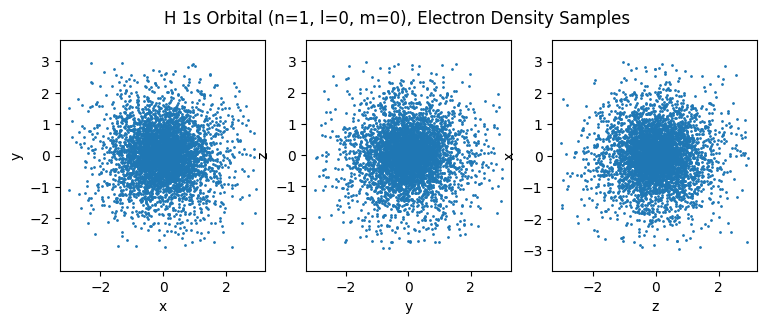

3.5427971039490624 7
2.8860492928551644 8
2.9571067619598628 8


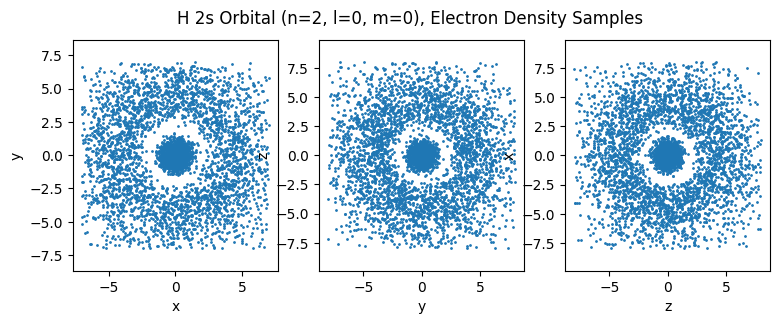

2.0297031176121935e-33 9
0.5398976489381189 9
0.5412321171966217 9


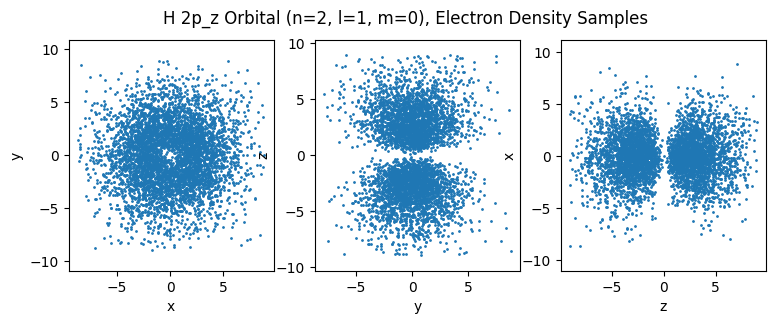

0.5413411059967895 9
0.5412040045926892 9
0.5397276868742125 9


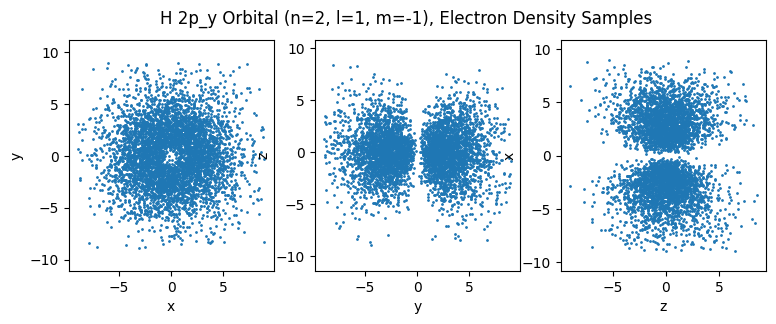

0.5413407313449337 9
0.5384742544777243 9
0.5412037595116599 9


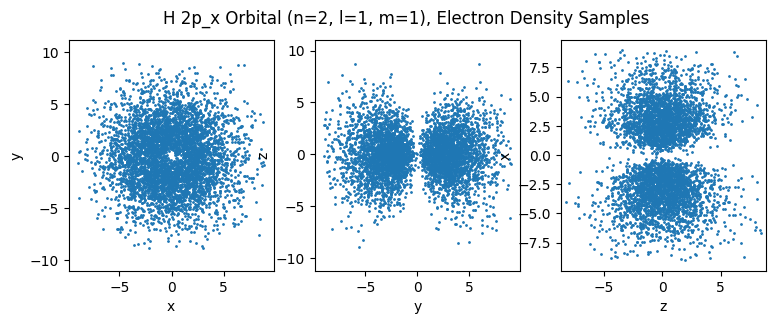

549.9512584852707 14
635.7740708142179 14
669.4665528304936 13


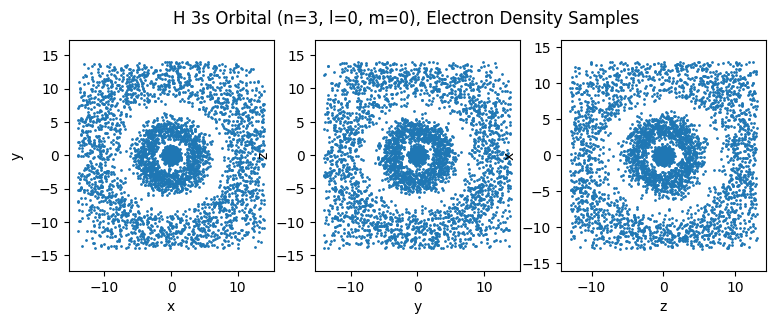

6.45870267134528e-32 18
17.174311138530303 17
17.215572735907383 17


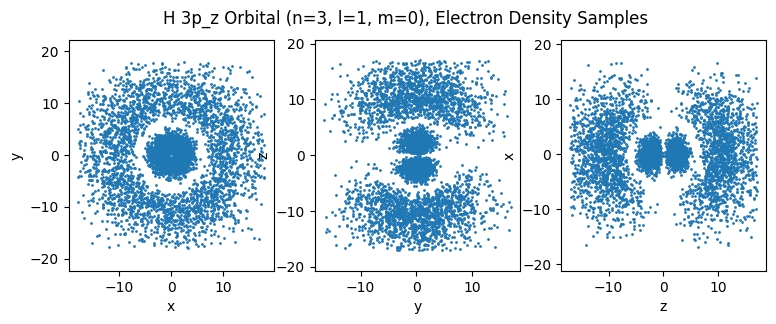

17.226061099173624 18
17.137602141370284 17
17.11487254767569 17


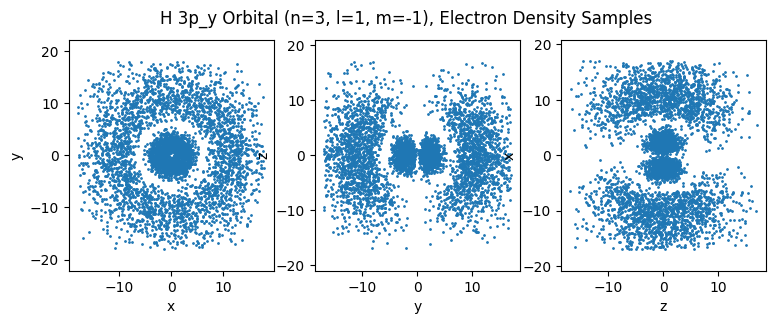

17.22604429244338 18
17.191673873090245 17
17.213620020764093 17


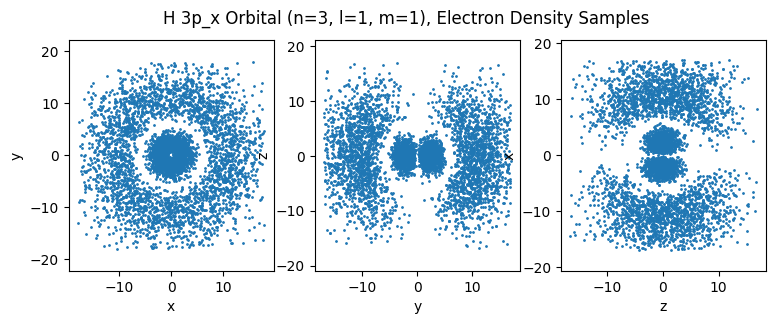

23.737067825523813 18
94.94087441632449 14
94.94647633072145 14


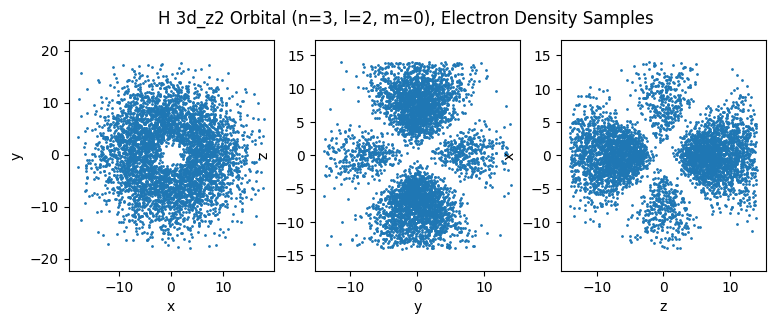

8.8999746564257e-32 18
5.933282935257196 18
5.9318390323252395 18


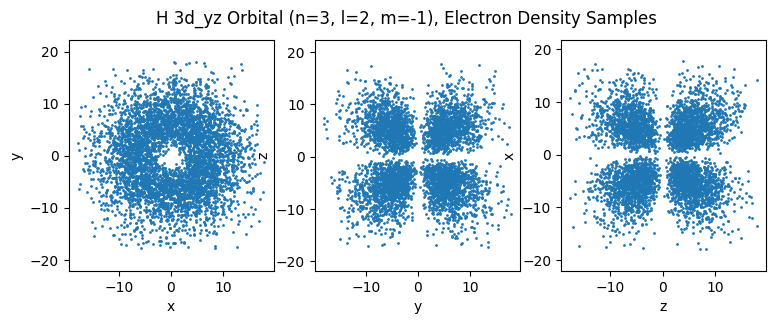

8.899974910012369e-32 18
5.932505428790104 18
5.9329531532294775 18


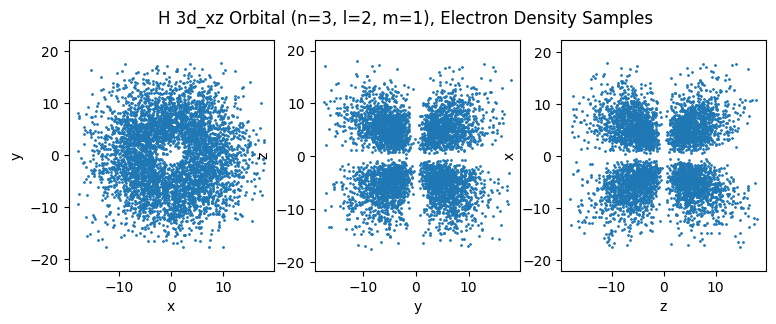

23.737067757420057 18
23.73535857301758 16
23.736663042212122 16


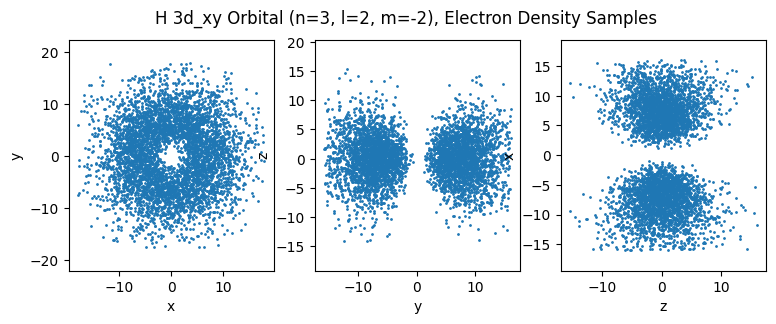

23.73706310303301 18
23.72987245542284 16
23.735176418612085 16


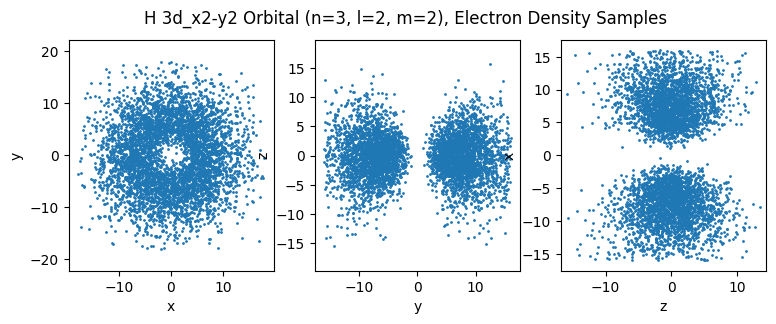

In [95]:
for key in orbitals:
# key = (2, 1, 0)
    orbital = orbitals.get(key)
    n, l, m = key
    samples = 5000
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    axes = (("x", "y"), ("y", "z"), ("z", "x"))

    for plane in range(3):
        pts = sample_distribution(orbital, n_samples=samples, plane=plane)
        ax[plane].scatter(pts[:, 0], pts[:, 1], s=1)
        ax[plane].axis('equal')
        ax[plane].set_xlabel(axes[plane][0])
        ax[plane].set_ylabel(axes[plane][1])

    fig.suptitle("H {name} Orbital (n={n}, l={l}, m={m}), Electron Density Samples".format(name=orbital_names[key], n=n, l=l, m=m))
    plt.show()